# "Classifying Bicycle Spare Parts with Deep Learning: A Trial"
> "This is the first post of my research work on convolutional neural networks, a family of neural networks mostly used (but not only) for solving computer vision problems."

- toc: true
- badges: false
- show_tags: false
- comments: true

This personal research work should help me getting a sound understanding of how convolutional neural networks work under the hood. Notebooks help mixing computer science practice and deep learning theory.
<br>
**Note:** This notebook is implemented with the fastai library, built atop PyTorch. Experiments are greatly inspired from Howard's and Gugger's book *Deep Learning for Coders with fastai and PyTorch*.

## Introduction

The goal here is to build a classifier for distinguishing between bicycle spare parts. When looking for parts, one of the most tedious tasks is to differentiate between different versions of a given part called a cassette. The cassette is a block of sprockets located on the bicycle rear wheel and ensuring the transmission of the power applied on the pedals to the rear wheel via the chain, hence making the bike moving forward. Most today's bicycle drivetrains use either 10-, 11- or 12-sprocket cassettes. Distinguishing between these at first glance is not easy, as can be seen below. In fact what we just see is just a mass of cogs.

![](images/cassettes.png "From left to right: 10-, 11- and 12-speed cassettes")

Distinguishing between types of cassettes is crucial though, because not all cassettes can be used with all chains and all shifters on a bicycle. 10-speed cassettes go with 10-speed drivetrains, etc.

On could argue that it's just about counting the sprockets, or reading the numbers written on the lockring (the smallest and darkest ring of the cassette), but it's not always as easy, especially with greasy or muddy parts, or even with old ones where nothing can be read anymore.

Let's assess if such objects are understandable and can be represented in such a manner that a neural network can distinguish between their types.

## Gathering Data

This notebook uses tilities provided by fast.ai authors, namely the fastbook library. This library comes with classes and modules that will help us setting up deep learing models.

In [1]:
#hide
!pip install -Uqq fastbook

     |████████████████████████████████| 720 kB 7.3 MB/s 
     |████████████████████████████████| 46 kB 5.4 MB/s 
     |████████████████████████████████| 189 kB 60.8 MB/s 
     |████████████████████████████████| 1.2 MB 48.6 MB/s 
     |████████████████████████████████| 56 kB 5.8 MB/s 
     |████████████████████████████████| 51 kB 413 kB/s 


In [2]:
#hide
import fastbook
fastbook.setup_book()
from fastbook import *

Mounted at /content/gdrive


fastai authors have built a tool that allows to download images from search engines, thus ensuring we can build our image dataset. Here we'll be using the most up-to-date version of the class, scrapping images from DuckDuckGo search results. Latest version and tutorial can be found on [fast.ai book's website](https://course.fast.ai/images).
For the sake of time-saving and reproducibility, we'll limit the dataset to 100 images of each type of cassette we're trying to identify.

Images are scrapped from the Internet and stored in a folder created for each type of cassette. Some additional steps consist of checking if all images are in the create folders and if there are no corrupted files, since they've been downloaded from the Internet. Corrupted files are eventually discarded.

In [3]:
#hide
# Download URLs for all of our search terms
cassette_types = ('10 speed', '11 speed', '12 speed')
path = Path('cassettes')

if not path.exists():
  path.mkdir()
for c in cassette_types:
  dest = (path/c)
  dest.mkdir(exist_ok=True)
  results = search_images_ddg('{} bicycle cassette'.format(c), max_images=100)
  download_images(urls=results, dest=dest)

In [4]:
#hide_input
print('Download complete.\n')
# Check images are located in the destination folder
fns = get_image_files(path)
print('{} downloaded files.'.format(len(fns)))

# Check if some files are corrupt
failed = verify_images(fns)
print('{} corrupted file(s).'.format(len(failed)))

# Remove failed images
failed.map(Path.unlink);

Download complete.

296 downloaded files.
1 corrupted file(s).


Let's have a look at a some images taken at random from the downloaded dataset.

In [46]:
#hide
import random

sample_size = 6
sampled_images = [fns[i] for i in random.sample(range(len(fns)), sample_size)]

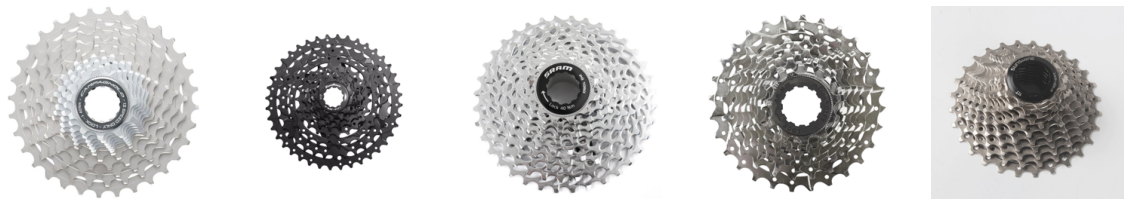

In [132]:
#hide_input
import matplotlib.pylab as plt

fig, axs = plt.subplots(1, 5, figsize=(20, 30))
for ax, im in zip(axs, sampled_images):
  img = Image.open(im).to_thumb(256, 256)
  ax.imshow(img)
  ax.axis('off');
plt.show()


Clearly there's no other way of distinguishing between cassette types than counting the number of sprockets. Following steps hopefully will lead us to build a model that will wisely represent each image to be able to identify each class.

## Preparing Data for Training The Network

### Creating Suitable Data Structures

Convolutional neural networks accept images as inputs. They won't accept jpg, png, or any other image file format though. Generally speaking, when developing deep learning models, our first thoughts must concern data representation, be it technically or conceptually.

Technically, models accept numbers. Deal with it. We'll have to find a way of passing our downloaded images to the model we'll build in a way the model will be able to process them and produce outputs from them.
Conceptually, before diving headfirst in code, carefully thinking of a way of representing raw data can save hours and prevent headaches that could arise when dealing with neural network architecture considerations.

We must also define how to create the sets used for training and evaluating our model. Here, the variable to predict (the *dependent* variable) is a category of cassette $-$ 10-, 11- or 12-speed. The inputs used by the model for outputing classifications (the *independent* variables) are cassette images. Building the training and validation sets must be carried out carefully, and significant performance improvements can come only from a wise selection of training and validation examples for feeding a network. Here we'll perform random splitting of the images, with a fraction of 20% being used as validation set.

Images downloaded are of different sizes. We can have a look at the size distribution below (for the sake of clarity, only sizes counting more than 10 images have been plotted here). This is a problem since we won't feed our network one image at a time, but rather batches of images (technically we're feeding *mini-batches*, but this will be discussed later). Before grouping it into a structure that can be sliced into such mini-batches, we need to resize the images to the same size.

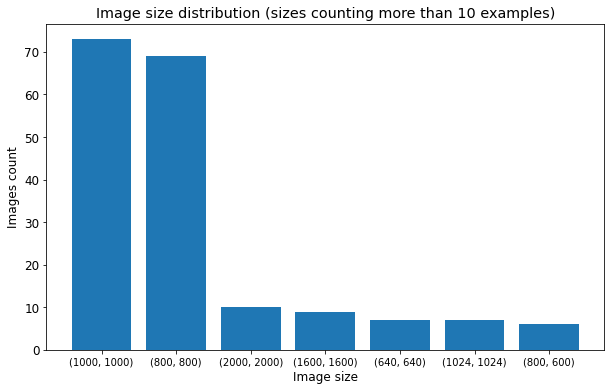

In [125]:
#hide_input
import collections

sizes = []
for img in fns:
  try:
    img_size = Image.open(img).size
    sizes.append(img_size)
  except FileNotFoundError:
    pass

counter = collections.Counter(sizes)
counts = {str(k): v for k, v in counter.items() if v > 5}
df = pd.Series(counts).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(range(len(df)), df.values, align='center')
plt.xticks(range(len(df)), df.index.values, size='small')
plt.title('Image size distribution (sizes counting more than 10 examples)');
plt.xlabel('Image size');
plt.ylabel('Images count');
plt.show()

In [127]:
#hide

cassettes = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

dls = cassettes.dataloaders(path)

Once all these preparation steps have been defined and carried out, we're ready to build our data structures and provide them to the network. We can look at a few images from the training and validation batches we just created.

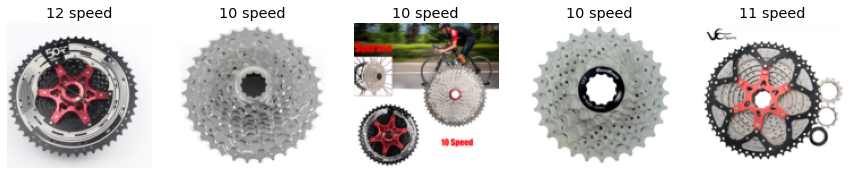

In [131]:
#hide

dls.train.show_batch(max_n=5, nrows=1)

Let's pause a second for an important word here: resizing images will somewhat modify the reality. The model will be fed with images that may be cropped, stretched, etc. 

A very crucial point in machine learning (and consequently in deep learning) is that a models cannot perform on concepts they haven't been trained on. Feeding a neural network with black and white images and then trying to produce outputs on never-seen coloured images can only result in poor performance. The goal of deep learning is to find *useful* representations of data, be it in a humanly understandable space or not. Models cannot invent representations while they haven't been trained on, they're just searching for better and more explainable representations of the input data. That's why data preparation is maybe the most important point in building deep learning models.

### Data Augmentation